# 1. Problem Statement:
 ## To classify cat images between 5 breeds with a CNN Model 

## 1a. Import libraries

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import pathlib
import seaborn as sns
import warnings
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

## 1b. Import Data

In [5]:
# Shell command: kaggle datasets download -d yapwh1208/cats-breed-dataset

In [6]:
# #Running will list all the files under this input directory
# import os
# for dirname, _, filenames in os.walk('/Users/lindaji/Downloads/03 Machine Learning/ML Project/cat_v1'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
data_dir = "/Users/lindaji/Downloads/03 Machine Learning/ML Project/cat_v1"
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

888


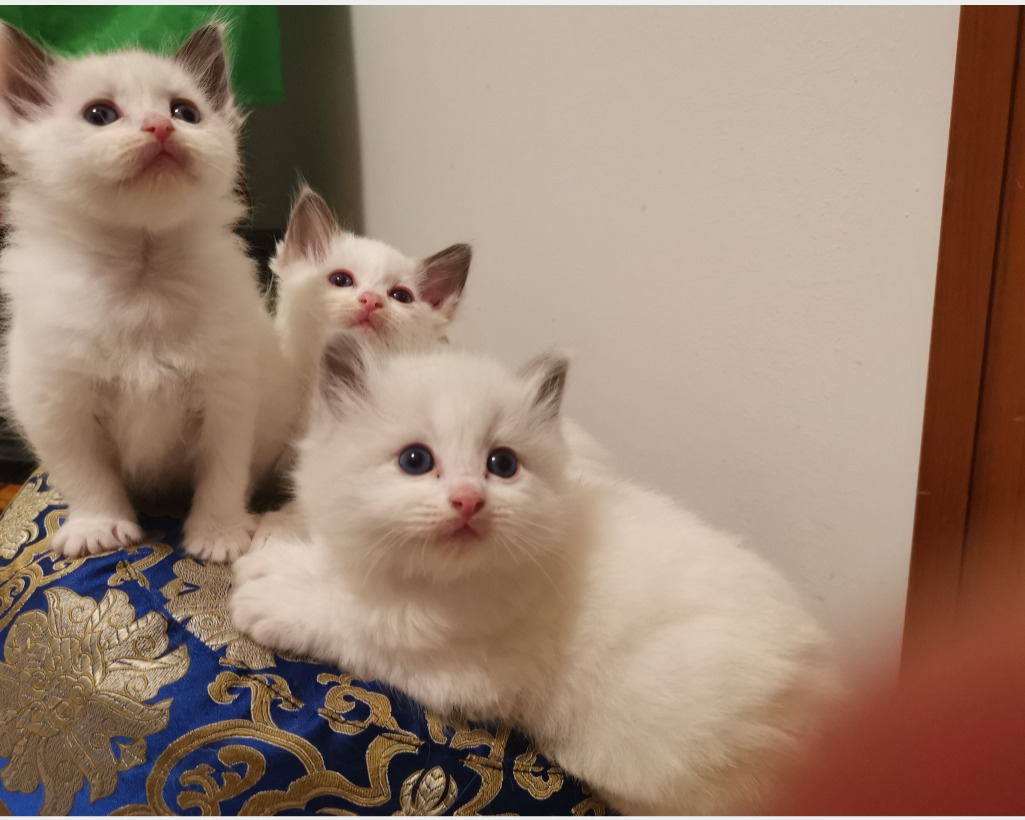

In [8]:
ragdoll = list(data_dir.glob('ragdoll/*'))
PIL.Image.open(str(ragdoll[0]))

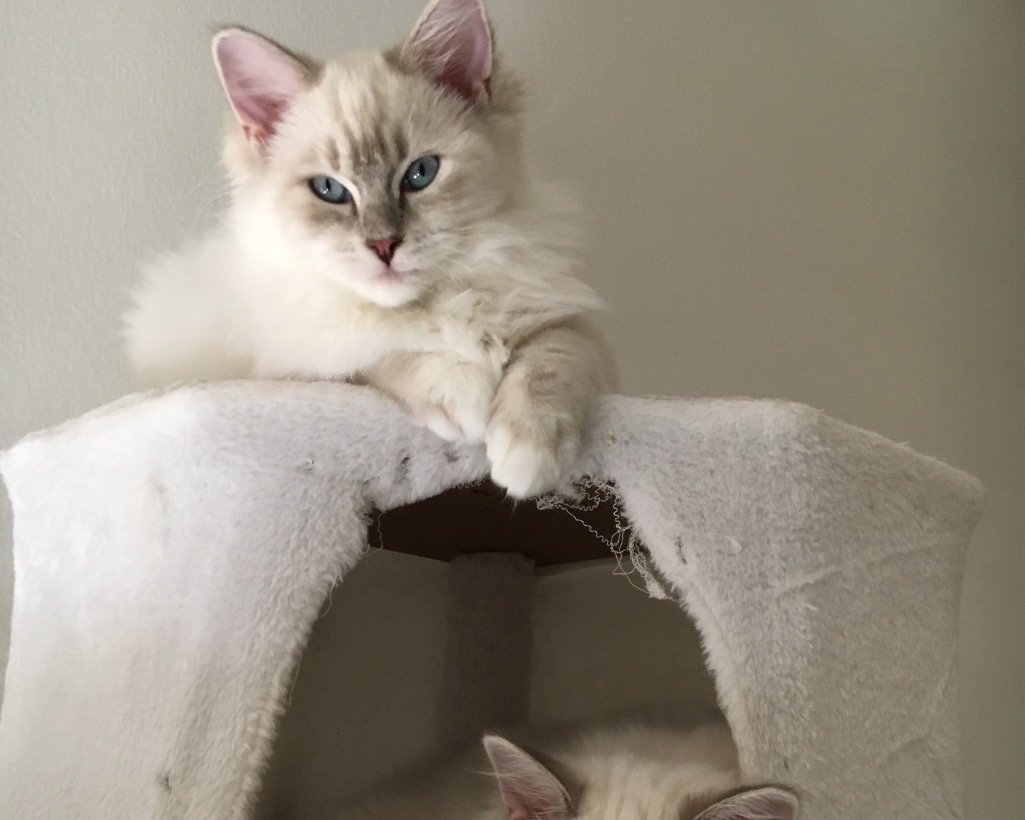

In [10]:
PIL.Image.open(str(ragdoll[1]))

 
# 2. Assumptions/Hypotheses about data and model
- 1. Diverse and Representative Dataset:
    - Assumption: The dataset contains a diverse and representative set of images for each of the 5 cat breeds.
    - Hypothesis: If the dataset is diverse and well-balanced, the CNN model will be able to learn distinguishing features effectively, leading to high classification accuracy.
- 2. High-Quality Images:
    - Assumption: The images in the dataset are of high quality, with minimal noise and clear depictions of the cats.
    - Hypothesis: High-quality images will enable the CNN to learn more accurate features and patterns, improving the model's performance in classifying the breeds.
- 3. Consistent Image Preprocessing:
    - Assumption: All images are preprocessed consistently, including resizing to a standard dimension, normalization, and potentially data augmentation.
    -Hypothesis: Consistent preprocessing will help the model generalize better by reducing variability that is not related to the breeds, thereby enhancing classification accuracy.
- 4. Adequate Training Data:
    - Assumption: There is a sufficient amount of training data for each of the 5 cat breeds to prevent overfitting and underfitting.
    - Hypothesis: With an adequate amount of training data, the CNN model will have enough examples to learn from, resulting in better generalization to new, unseen images and higher overall accuracy.


# 3. Exploratory Data Analysis

## i. Found 5 different classes with a sample dataset of 951 files

In [14]:
raw_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,)

Found 951 files belonging to 5 classes.


In [15]:
raw_ds.take(0)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## ii. Visualize sample images

In [21]:
# Extract class names
class_names = raw_ds.class_names

2024-05-22 13:11:26.917843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


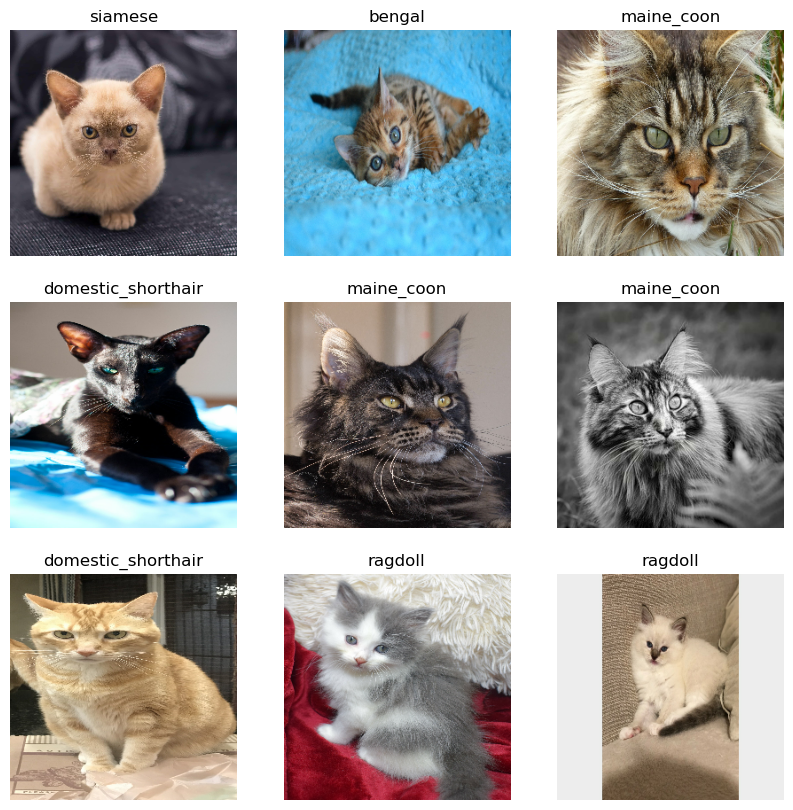

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in raw_ds.take(5):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
# Checking indexing format
class_names[labels[0]]

'siamese'

In [27]:
# Initialize dictionary and lists
class_counts = {class_name: 0 for class_name in class_names}
image_shapes = []
all_pixels = []

# Iterate through the dataset for counts of each class and get image shapes
for images, labels in raw_ds:
    for image, label in zip(images, labels):
        class_name = class_names[label]
        class_counts[class_name] += 1
        image_shapes.append(image.shape)
        all_pixels.extend(image.numpy().flatten())  # Convert tensor to numpy array and flatten

# Convert the dictionary to lists for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())
# Convert all_pixels list to a numpy array
all_pixels = np.array(all_pixels)

2024-05-22 13:11:42.969890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## iii. Class Distribution: Seems relatively uniform but not exactly the same

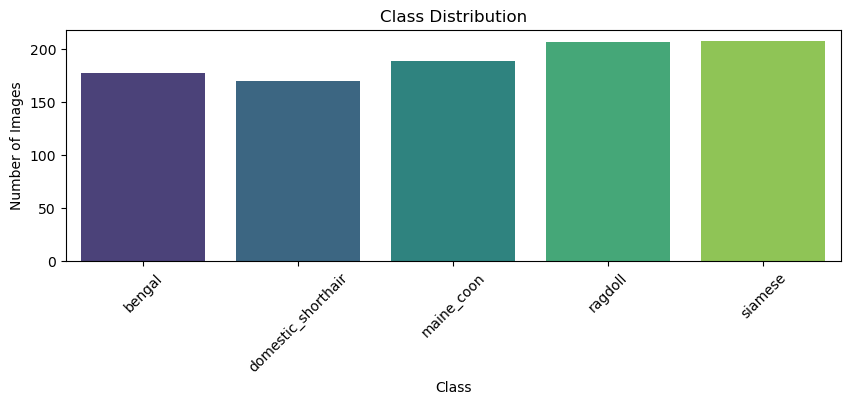

In [28]:
# Define a color palette
palette = sns.color_palette("viridis", len(classes)) 

plt.figure(figsize=(10, 3))
sns.barplot(x=classes, y=counts, palette=palette)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

2. Image Dimensions and Channels
Image Sizes: Examine the dimensions of the images to ensure consistency. If images have different sizes, note this for preprocessing.
Color Channels: Check if images are grayscale, RGB, or have more channels. This impacts the input shape of the CNN.

3. Data Quality
Missing Data: Identify any missing or corrupt images.
Image Quality: Look for images with poor quality, such as blurriness, overexposure, or underexposure.
4. Metadata and Labels
Label Verification: Ensure that labels are correctly assigned to images.
Metadata Analysis: If available, analyze metadata like the date taken, device used, etc., for any useful insights.
5. Statistical Analysis
Pixel Intensity Distribution: Plot histograms of pixel intensities to understand the distribution of pixel values.
Color Channel Statistics: For RGB images, analyze the mean and standard deviation of each color channel.
6. Visual Analysis
Principal Component Analysis (PCA): Apply PCA to visualize the dataset in lower dimensions.
T-SNE: Use t-SNE for another dimensionality reduction technique to visualize high-dimensional data.
7. Augmentation Strategies
Augmentation Techniques: Explore various augmentation techniques such as rotation, flipping, zooming, and contrast adjustments. Visualize augmented images to ensure they are reasonable.
8. Preprocessing Needs
Normalization: Decide on normalization strategies based on pixel intensity distributions.
Resizing: Determine the appropriate size to which all images should be resized.
Code Examples

## iv. Checking image dimensions and channel image size:
The dimensions have the same size- although the sizes will still be adjusted later on so they are smaller and more easy to process

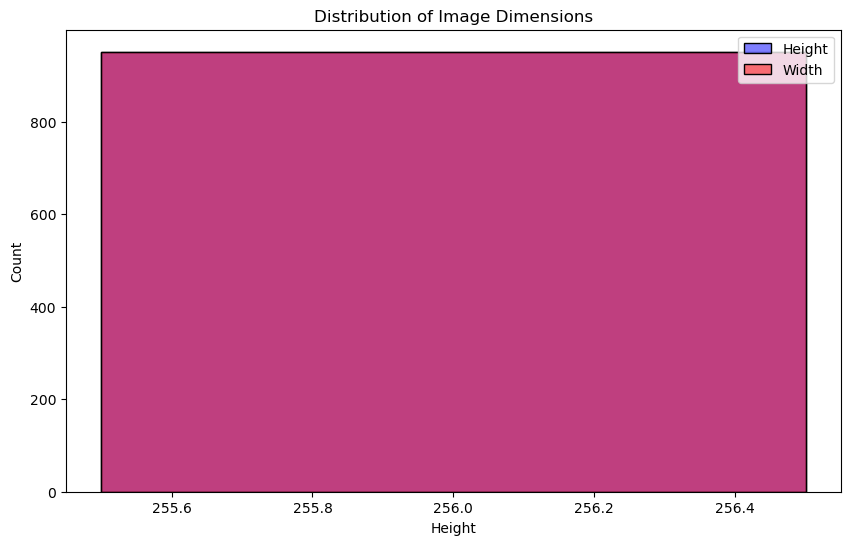

In [29]:
# Create a DataFrame for image shapes
shape_df = pd.DataFrame(image_shapes, columns=['Height', 'Width', 'Channels'])

# Plot the distribution of image dimensions
plt.figure(figsize=(10, 6))
sns.histplot(shape_df['Height'], kde=True, color='blue', label='Height')
sns.histplot(shape_df['Width'], kde=True, color='red', label='Width')
plt.title('Distribution of Image Dimensions')
plt.legend()
plt.show()

## v. Pixel Intensity Distribution
- Uniform Distribution:
The central portion of the histogram (pixel intensity 20 to 230) is fairly uniform, indicating evenly distributed pixel values in this range.
- Peaks at Extremes:
    - Dark Pixels (0-20): A significant number of very dark pixels (near black).
    - Bright Pixels (230-255): A significant number of very bright pixels (near white).
- Interpretation:
    - Balanced Dataset: The uniform middle range suggests a varied dataset with different pixel values.
    - High Contrast Images: Peaks at the extremes indicate high contrast areas, possibly due to text, shadows, or highlights.
- Potential Preprocessing:
    - Normalization: Scaling pixel values to a range like 0-1 can enhance CNN model performance.

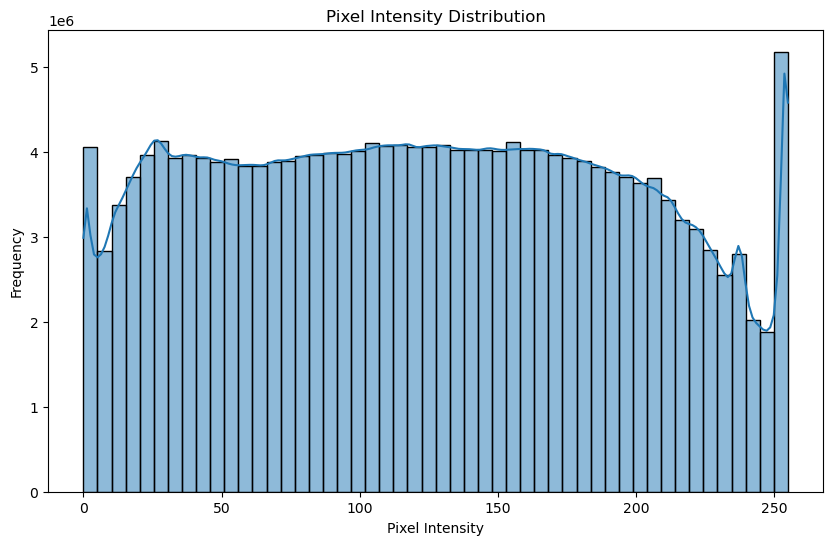

In [30]:
# Plot the pixel intensity distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_pixels, bins=50, kde=True)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# 4. Feature Engineering & Transformations
## i. Resize images
## ii. Split test and triain set with seed for reproducibility
## iii. Standardize data
## iv. Data Augmentation

In [12]:
# Resize Images:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
# Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 951 files belonging to 5 classes.
Using 761 files for training.


In [16]:
# Test set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 951 files belonging to 5 classes.
Using 190 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['bengal', 'domestic_shorthair', 'maine_coon', 'ragdoll', 'siamese']


In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


2024-05-22 15:53:43.121953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


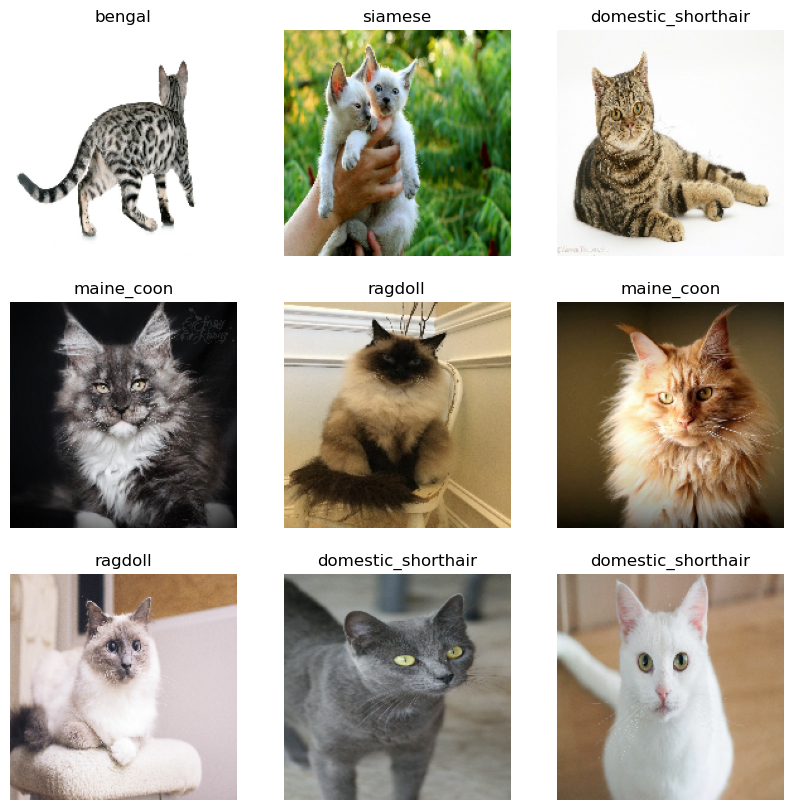

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
#Standardize data
normalization_layer = layers.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.028103938 0.7229848


In [29]:
augment_data = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-05-22 13:14:55.290988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


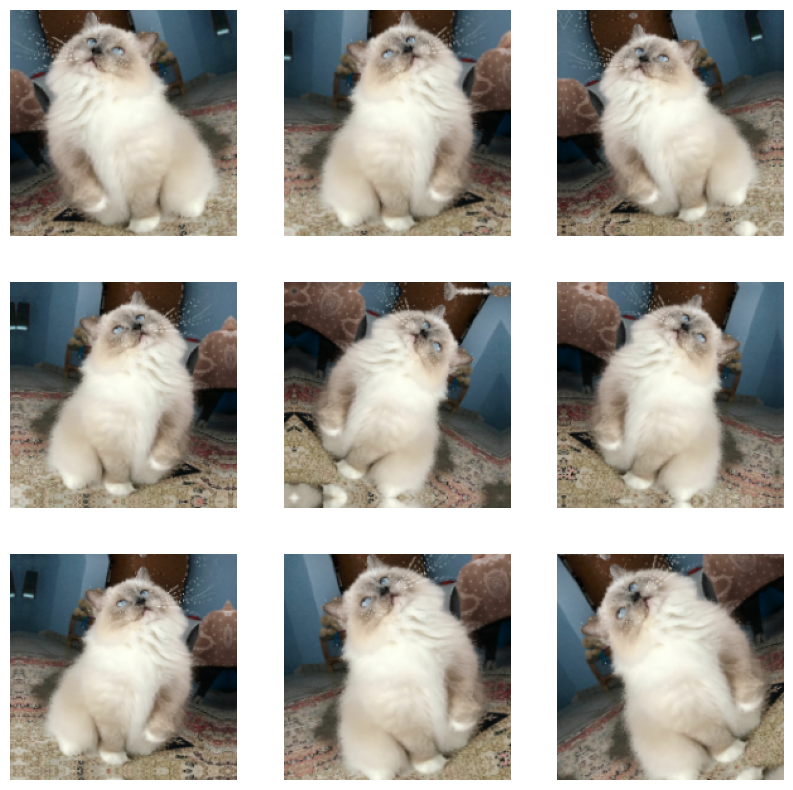

In [44]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augment_data(images)[0].numpy().astype("uint8"))
    plt.axis("off")

# 5. Proposed Approaches (Model) with checks for overfitting/underfitting


## Model 1

In [116]:
# Building Model

num_classes = len(class_names)

model = Sequential([
  augment_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [118]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [120]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [122]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.2191 - loss: 2.0123 - val_accuracy: 0.3000 - val_loss: 1.6015
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.3262 - loss: 1.5661 - val_accuracy: 0.4000 - val_loss: 1.4499
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.3530 - loss: 1.4494 - val_accuracy: 0.4474 - val_loss: 1.4174
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.4140 - loss: 1.3949 - val_accuracy: 0.4000 - val_loss: 1.3530
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.4396 - loss: 1.2708 - val_accuracy: 0.4368 - val_loss: 1.3428
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.4453 - loss: 1.3064 - val_accuracy: 0.4737 - val_loss: 1.3237
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.5154 - loss: 1.1766 - val_accuracy: 0.4684 - val_loss: 1.2856
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.4671 - loss: 1.2832 - val_accuracy: 0.

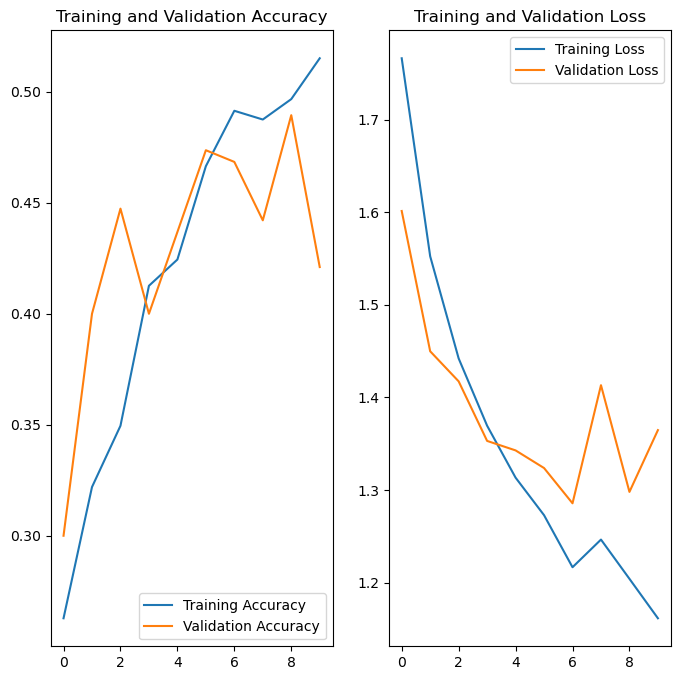

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## i. Testing outside images

In [75]:
import pathlib
import tensorflow as tf
import numpy as np

# Define the directory and image path
test_dir = "/Users/lindaji/Downloads/03 Machine Learning/ML Project/cat_test"
test_path = pathlib.Path(test_dir) / 'maine_coon_1.jpg'  
img_height = 180  
img_width = 180   

# Load and preprocess the image
img = tf.keras.utils.load_img(
    str(test_path), target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Assuming class_names is defined and contains the correct labels
class_names = ['bengal', 'domestic_shorthair', 'maine_coon', 'ragdoll', 'siamese']  # Replace with your actual class names

# Print the result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
This image most likely belongs to maine_coon with a 56.86 percent confidence.


In [83]:
test_dir = "/Users/lindaji/Downloads/03 Machine Learning/ML Project/cat_test"
test_path2 = pathlib.Path(test_dir) / 'rag_doll_bengal_hybrid.jpg'  
img_height = 180  
img_width = 180   

# Load and preprocess the image
img2 = tf.keras.utils.load_img(
    str(test_path2), target_size=(img_height, img_width)
)
img_array2 = tf.keras.utils.img_to_array(img2)
img_array2 = tf.expand_dims(img_array2, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array2)
score = tf.nn.softmax(predictions[0])

# Assuming class_names is defined and contains the correct labels
class_names = ['bengal', 'domestic_shorthair', 'maine_coon', 'ragdoll', 'siamese']  # Replace with your actual class names

# Print the result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
This image most likely belongs to maine_coon with a 37.09 percent confidence.


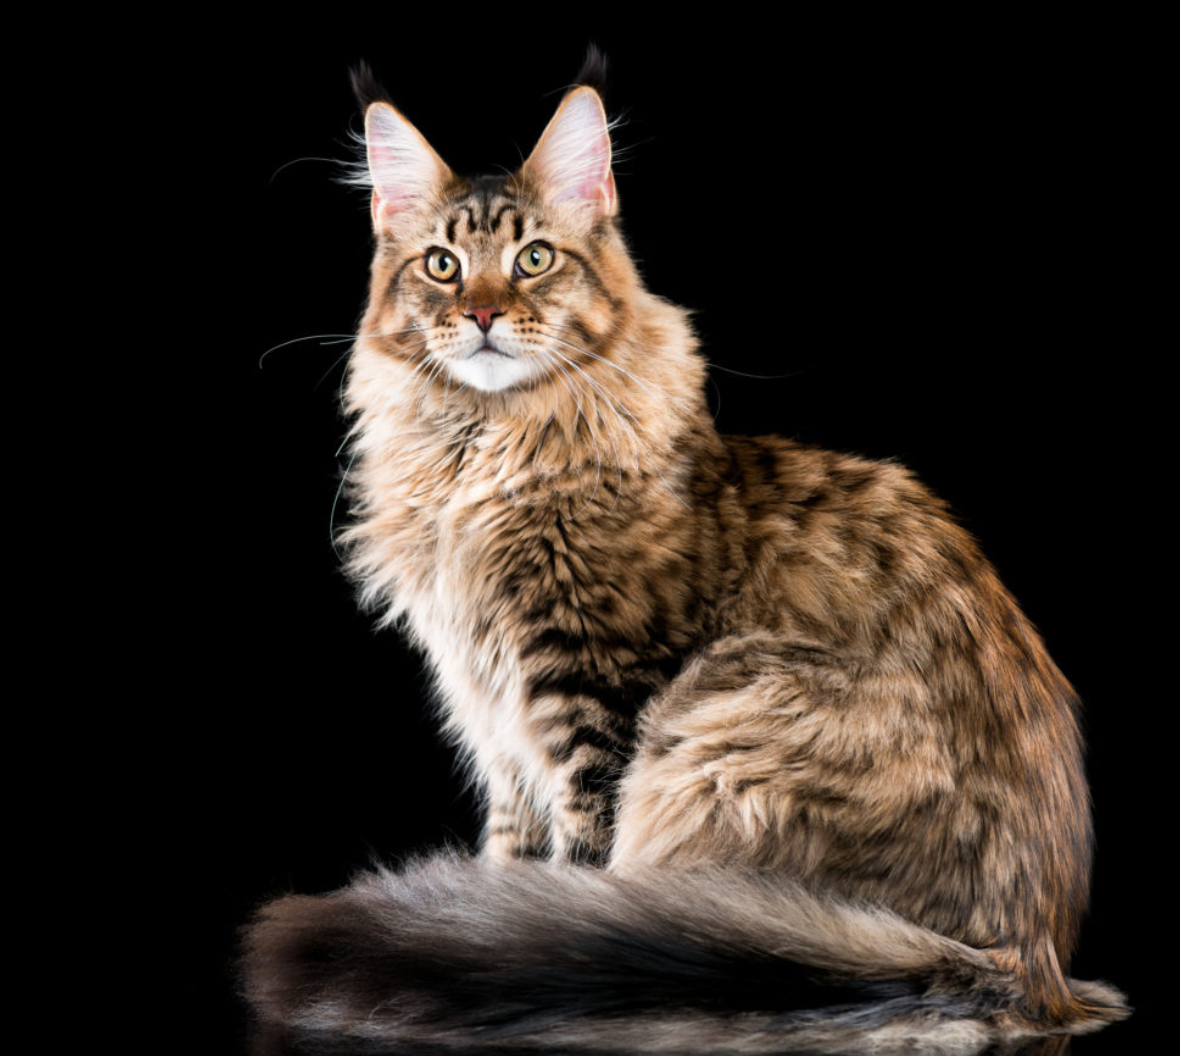

In [77]:
PIL.Image.open(test_path)

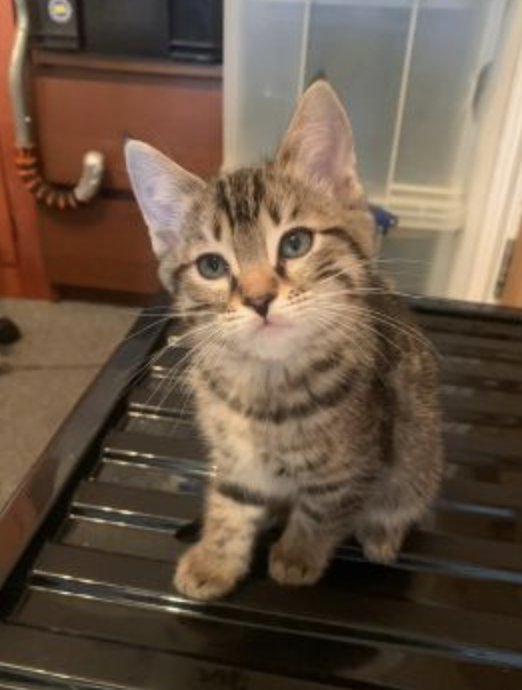

In [85]:
PIL.Image.open(test_path2)

# 6. Proposed Solution (Model Selection) with regularization, if needed

The graphs show training and validation accuracy and loss over epochs, indicating fluctuations and potential overfitting. To address these issues, we can introduce regularization techniques such as L2 regularization and early stopping.
## 1. Using hyperparameter tuning:
Try using keras tuner to test for the best parameters

## 2. Add L2 Regularization:
L2 regularization (also known as weight decay) can be applied to the layers to penalize large weights and reduce overfitting.
- kernel_regularizer=regularizers.l2(0.01))

## 3. Use Early Stopping:
Early stopping monitors the validation loss and stops training when it stops improving, preventing overfitting and saving training time.
- patience=3

In [198]:
# pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 984.1 kB/s eta 0:00:00 0:00:01m
Note: you may need to restart the kernel to use updated packages.


In [200]:
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner
from tensorflow import keras

In [90]:
# Define number of classes
num_classes = len(class_names)

## Model 3: Using Hyperparameter tuning

In [189]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

In [202]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [233]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(augment_data)
        model.add(layers.Rescaling(1./255))
        
        # Tune the number of filters in the Conv2D layers
        model.add(layers.Conv2D(
            filters=hp.Int('filters', min_value=16, max_value=64, step=16),
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=layers.regularizers.l2(hp.Float('l2', min_value=0.0, max_value=0.01, step=0.001))
        ))
        model.add(layers.MaxPooling2D())
        
        model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        
        model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
        model.add(layers.MaxPooling2D())
        
        model.add(layers.Flatten())
        
        # Tune the number of units in the Dense layer
        model.add(layers.Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu',
            kernel_regularizer=layers.regularizers.l2(hp.Float('l2_dense', min_value=0.0, max_value=0.01, step=0.001))
        ))
        
        model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        
        model.add(layers.Dense(num_classes))
        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            ),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )  
        return model


In [212]:
# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(val_ds)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5107 - loss: 1.2904
Final Test Accuracy: 0.4842


## Model 2: Regularization & early stopping

In [176]:
# Building the model with additional regularization
model2 = Sequential([
    augment_data,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(num_classes)
])

In [178]:
# Compile the model
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [180]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [237]:
model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,967,857 (45.65 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,978,572 (30.44 MB)

In [184]:
# Train the model
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 0.2263 - loss: 4.0189 - val_accuracy: 0.1737 - val_loss: 2.5603
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.2397 - loss: 2.3819 - val_accuracy: 0.3105 - val_loss: 2.0028
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.3709 - loss: 1.9181 - val_accuracy: 0.3368 - val_loss: 1.8519
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.3804 - loss: 1.7375 - val_accuracy: 0.3368 - val_loss: 1.6849
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.4358 - loss: 1.6636 - val_accuracy: 0.4368 - val_loss: 1.6077
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.4396 - loss: 1.5895 - val_accuracy: 0.4158 - val_loss: 1.5631
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.4514 - loss: 1.5508 - val_accuracy: 0.4316 - val_loss: 1.5562
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.4536 - loss: 1.5496 - val_accuracy: 0.

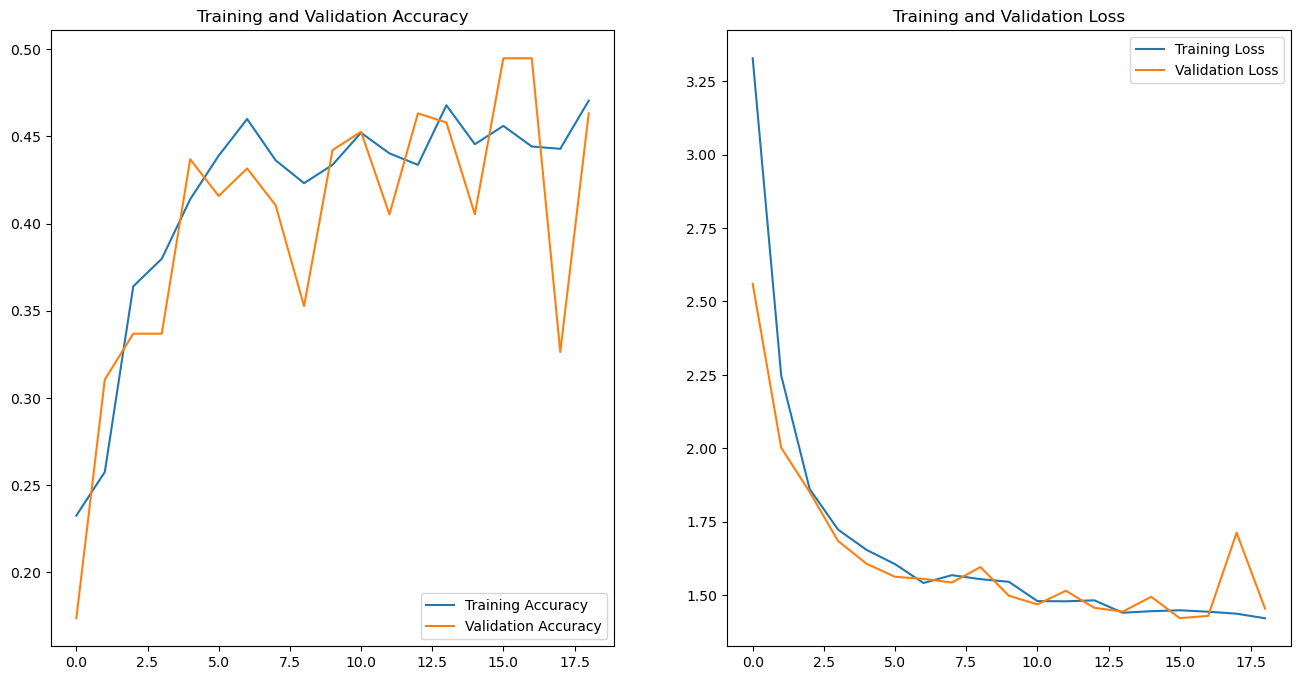

In [185]:
# Extract accuracy and loss history from history2
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Define the range of epochs based on the length of accuracy history
epochs_range = range(len(acc))

# Plot training and validation accuracy and loss
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


## Model 4: Adding More Layers on top of model 2

In [54]:


# Define the data augmentation pipeline
augment_data = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
    ]
)

In [56]:
from tensorflow.keras import layers, regularizers, Sequential
num_classes=5
# Building the improved model with additional layers and regularization
model4 = Sequential([
    augment_data,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model4.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [68]:
# Train the model
history4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=7.5, restore_best_weights=True)]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 598ms/step - accuracy: 0.3100 - loss: 2.6552 - val_accuracy: 0.4526 - val_loss: 3.2910
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 595ms/step - accuracy: 0.3705 - loss: 3.3395 - val_accuracy: 0.2105 - val_loss: 6.4215
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step - accuracy: 0.4133 - loss: 3.0818 - val_accuracy: 0.2684 - val_loss: 3.1132
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 593ms/step - accuracy: 0.3442 - loss: 2.8092 - val_accuracy: 0.3421 - val_loss: 2.6508
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 596ms/step - accuracy: 0.3689 - loss: 2.5891 - val_accuracy: 0.3895 - val_loss: 2.6928
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 606ms/step - accuracy: 0.3537 - loss: 2.3677 - val_accuracy: 0.3526 - val_loss: 2.2860
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 605ms/step - accuracy: 0.3282 - loss: 2.2173 - val_accuracy: 0.3211 - val_loss: 2.3717
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 605ms/step - accuracy: 0.3725 - loss: 2.0398 - val_accu

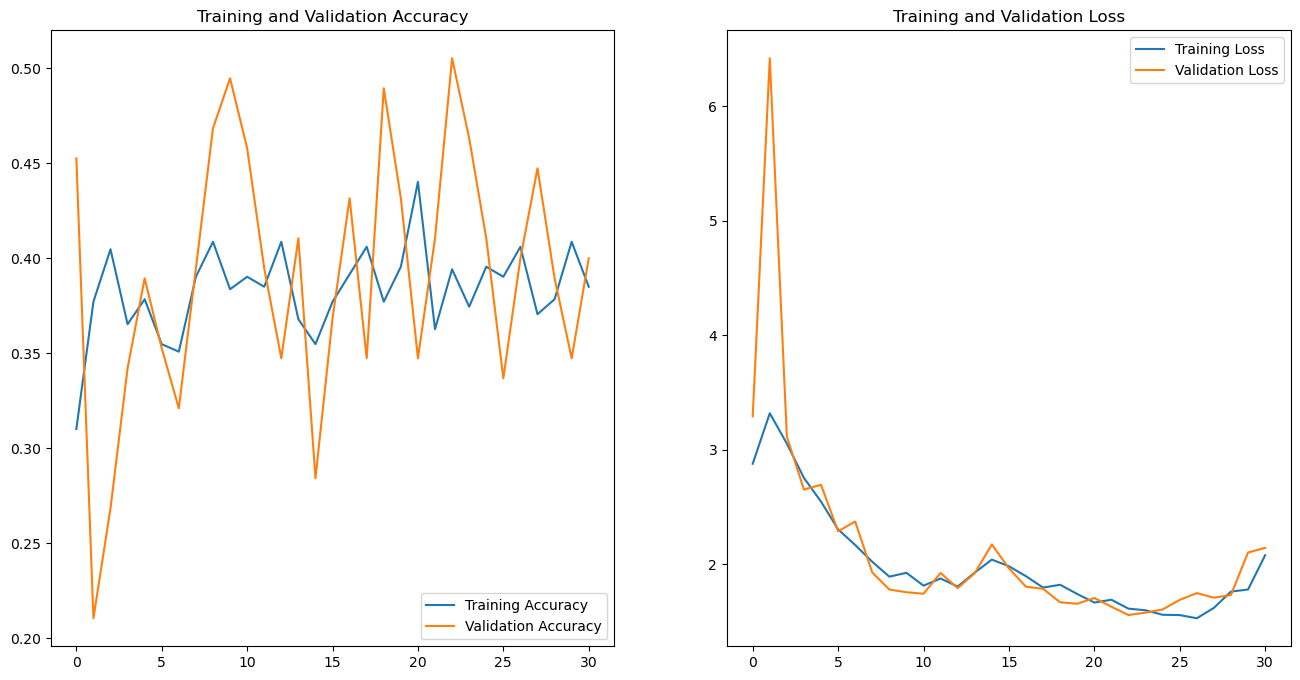

In [72]:
# Plot training and validation accuracy and loss
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 7. Results (Accuracy) and Learnings from the methodology

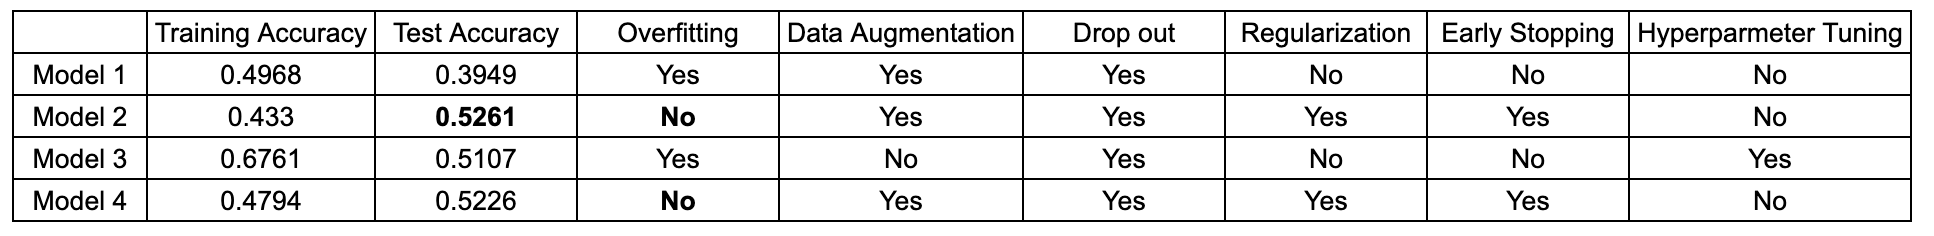


## Evaluation of accuracy: 
- Model 1: 
    - Initially with only 10 epochs show signs of overfitting thus adding regularization and early stopping with 50 epochs show significant increase in test accuracy for Model 2
- Model 2:  
    - shows the highest accuracy with data augmentation, dropout, regularization and early stopping. The adding of regularization also shows improvement in the training loss and validation loss graphs.  
- Model 3: 
    - Hyper parameter tuning with random search shows comparable accuracy, but still slightly lower than model 2, indication that regularization and early stopping might still be needed.
- Model 4: 
    - This is testing with more layers to the CNN, to see if it can increase accuracy with the same parameters as model 2. However accuracy is still slightly lower than model 2, showing more layers does not neccessarily mean better results

## i. Accuracy results: the original model with data augmentation, dropout, but without regularization & early stopping

In [257]:
# Evaluate the best model on the training set
train_loss, train_accuracy = model.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy:.4f}")

test_loss, test_accuracy = model.evaluate(val_ds)

# Print the final test accuracy
print(f"Final Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4968 - loss: 1.1852
Training Accuracy: 0.4875
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3949 - loss: 1.3405
Final Test Accuracy: 0.4211


## ii. Accuracy results: 2nd model with data augmentation, dropout, regularization & early stopping

In [259]:
# Evaluate the best model on the training set
train_loss, train_accuracy = model2.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(val_ds)

# Print the final test accuracy
print(f"Final Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4330 - loss: 1.4518
Training Accuracy: 0.4625
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5261 - loss: 1.4059
Final Test Accuracy: 0.4947


## iii. Accuracy results: 3nd model with dropout only & hyperparameter tuning

In [255]:
# Evaluate the best model on the training set
train_loss, train_accuracy = best_model.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(val_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6761 - loss: 0.9854
Training Accuracy: 0.6728
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5107 - loss: 1.2904
Test Accuracy: 0.4842


## iv. Accuracy results: 4th model with data augmentation, dropout(increased), regularization & early stopping(patience increased), more layers

In [70]:
train_loss, train_accuracy = model4.evaluate(train_ds)
print(f"Training Accuracy: {train_accuracy:.4f}")
# Evaluate the model on the test set
test_loss, test_accuracy = model4.evaluate(val_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.4794 - loss: 1.5620
Training Accuracy: 0.4875
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5226 - loss: 1.5617
Test Accuracy: 0.5053


# 8. Future Work
## Due to validation accuracy still being far from ideal- next possible steps to improve it:
- Using hyperparmeter tuning together with regularization and early stopping 
- Using GAN generator to increase dataset sample and runing with more epochs to minimal training loss
